# Lab 5: Introduction to Mining Time Series Data

At the time of writing this lab, COVID-19 is still the most topical public-health crisis globally. **The number of daily new cases worldwide** is a time series that arises naturally from this topical event, and in this lab we'll apply some of the techniques we learned in class to this very time series to discern any patterns it may contain.

In [ ]:
import numpy as nps
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GOOGLE_PATH_PREFIX = "drive/MyDrive/SI671-23FALL/Lab 5/"

### 1. Load the Data

You are provided with a csv file, `time_series_covid19_confirmed_global.csv`, which is part of the [Johns Hopkins University CSSE COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). As the name suggests, it contains the number of *cumulative* confirmed cases globally as of certain dates. However, we are interested in the number of *new* cases worldwide every day.

We will begin by reading in the csv file and producing a `pd.Series` that looks like:

```
2020-01-23        99.0
2020-01-24       287.0
2020-01-25       493.0
2020-01-26       684.0
2020-01-27       809.0
                ...   
2020-08-17    209672.0
2020-08-18    255096.0
2020-08-19    274346.0
2020-08-20    267183.0
2020-08-21    270751.0
Length: 212, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`;
* the values of the series are daily *new* cases worldwide; and
* the series doesn't contain any `NaN` values.

In [ ]:
# read in our data from the csv file
global_df = pd.read_csv(GOOGLE_PATH_PREFIX + "time_series_covid19_confirmed_global.csv")
global_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,977,981,989,989,989,1005,1005,1024,1024,1045
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068


In [ ]:
# filter to only date columns, then sum the values as we are interested in worldwide data
global_daily_cases = global_df.filter(regex=r"[0-9]+/[0-9]+/[0-9]+", axis="columns").sum(axis=0)
global_daily_cases # result is the number of cumulative cases each day

1/22/20         555
1/23/20         654
1/24/20         941
1/25/20        1434
1/26/20        2118
             ...   
8/17/20    21881858
8/18/20    22136954
8/19/20    22411300
8/20/20    22678483
8/21/20    22949234
Length: 213, dtype: int64

In [ ]:
# reformat dates to be pd.DateTimeIndex
global_daily_cases.index = pd.to_datetime(global_daily_cases.index, infer_datetime_format=True)
global_daily_cases

2020-01-22         555
2020-01-23         654
2020-01-24         941
2020-01-25        1434
2020-01-26        2118
                ...   
2020-08-17    21881858
2020-08-18    22136954
2020-08-19    22411300
2020-08-20    22678483
2020-08-21    22949234
Length: 213, dtype: int64

In [ ]:
# use diff method to compute the difference between the cumulative case count that day and the previous day
daily_new_cases = global_daily_cases.diff()
daily_new_cases

2020-01-22         NaN
2020-01-23        99.0
2020-01-24       287.0
2020-01-25       493.0
2020-01-26       684.0
                ...   
2020-08-17    209672.0
2020-08-18    255096.0
2020-08-19    274346.0
2020-08-20    267183.0
2020-08-21    270751.0
Length: 213, dtype: float64

In [ ]:
# drop na values
daily_new_cases.dropna(inplace = True)

In [ ]:
daily_new_cases.index # check - the index is composed of the dates

DatetimeIndex(['2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01',
               ...
               '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15',
               '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19',
               '2020-08-20', '2020-08-21'],
              dtype='datetime64[ns]', length=212, freq=None)

In [ ]:
daily_new_cases.values # check - the values are the new cases counts

array([9.90000e+01, 2.87000e+02, 4.93000e+02, 6.84000e+02, 8.09000e+02,
       2.65100e+03, 5.88000e+02, 2.06800e+03, 1.69300e+03, 2.11100e+03,
       4.74900e+03, 3.10000e+03, 4.01100e+03, 3.74500e+03, 3.15900e+03,
       3.59300e+03, 2.73400e+03, 3.03000e+03, 2.60900e+03, 2.04200e+03,
       4.18000e+02, 1.51530e+04, 6.52700e+03, 2.14200e+03, 2.18400e+03,
       2.03500e+03, 1.88200e+03, 5.00000e+02, 5.60000e+02, 6.29000e+02,
       1.76100e+03, 3.80000e+02, 5.64000e+02, 8.53000e+02, 9.77000e+02,
       1.36400e+03, 1.37700e+03, 1.89500e+03, 2.38400e+03, 1.97400e+03,
       2.57800e+03, 2.29900e+03, 2.79100e+03, 3.94300e+03, 4.03800e+03,
       3.95400e+03, 3.90000e+03, 5.02400e+03, 7.66300e+03, 5.75000e+03,
       1.44070e+04, 1.11080e+04, 1.11490e+04, 1.46670e+04, 1.58470e+04,
       1.95960e+04, 2.79190e+04, 2.96100e+04, 3.23090e+04, 3.34200e+04,
       4.21670e+04, 4.11670e+04, 5.08190e+04, 6.28970e+04, 6.44000e+04,
       6.76560e+04, 5.95770e+04, 6.46420e+04, 7.64100e+04, 7.621

In [ ]:
daily_new_cases.isna().any() # check - no NaN values

False

Text(0.5, 1.0, 'Daily New COVID-19 Cases Worldwide')

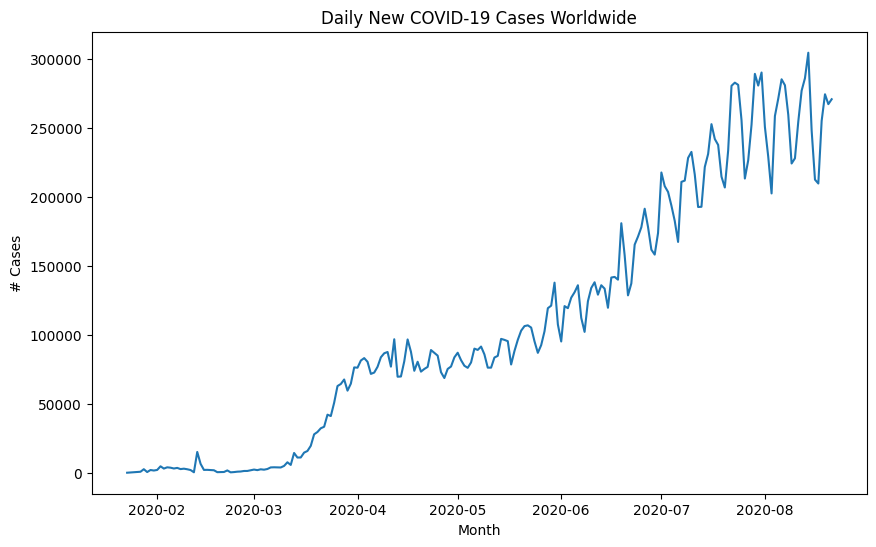

In [ ]:
# let's plot the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases)
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

Overall, we see a general increasing trend in the number of new daily cases during the selected time period.

### 2. Perform a Seasonal Decomposition

With the time series ready, let's first perform a seasonal decomposition using tools from the `statsmodels` library to get a sense of what possible patterns are hidden in the data. We will use the seasonal_decompose function that takes a time series and an argument `model`, which indicates whether an additive or multiplicative seasonal decomposition should be performed.

In this example, we will use an additive model. Recall from the lectures that an additive Seasonal Decomposition decomposes a time series into the following components:

\begin{equation*}
Y(t) = T(t) + S(t) + R(t)
\end{equation*}

where $T(t)$ represents trends, $S(t)$ represents seasonal patterns and $R(t)$ represents residuals.

In [ ]:
# apply seasonal decomposition function to data with 'additive' model
sea_decomp = seasonal_decompose(daily_new_cases, model="additive")
sea_decomp

Text(0.513, 0.95, 'Daily New COVID-19 Cases Worldwide')

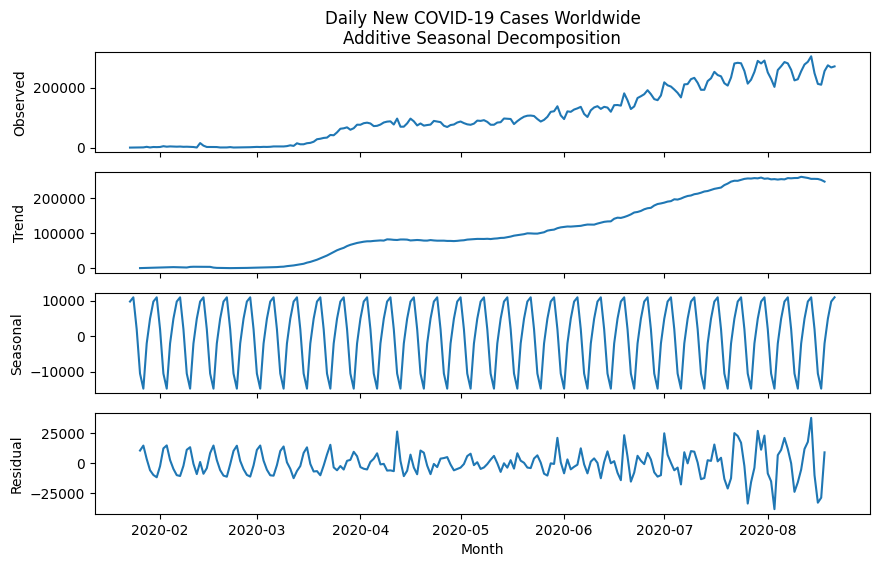

In [ ]:
# let's plot the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(sea_decomp.observed) # original/observed data
axes[0].set_ylabel("Observed")

axes[1].plot(sea_decomp.trend) # trend component
axes[1].set_ylabel("Trend")

axes[2].plot(sea_decomp.seasonal)
axes[2].set_ylabel("Seasonal") # seasonality component

axes[3].plot(sea_decomp.resid) #  time series with the trend and seasonal components removed
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Month")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

### 3. Fitting a Trend Curve

The plot above suggests that there is a non-linear trend hidden in the time series. One approach to discover such a trend is to fit a regression model to the time series and ask the regression model to make predictions at each timestamp. When connected, these chronological predictions form a "trend curve". Here, we will explore how to fit a trend curve to our time series.

We will fit a 10th order polynomial regression model to the input time series and use it to make predictions. A 10th order polynomial regression model assumes that each dependent variable $y_{i}$ is a 10th order polynomial function of the corresponding independent variable $x_{i}$:

\begin{equation*}
y_{i} = c_{0} + c_{1}x_{i} + c_{2}x_{i}^{2} + \cdots + c_{10}x_{i}^{10}
\end{equation*}

Now, the most interesting and important question to think about is, "**what are $x_{i}$'s and $y_{i}$'s in the problem?**". The $y_{i}$'s are the daily new cases worldwide at timestamps $x_{i}$'s, but **how should we represent the timestamps $x_{i}$'s in such a regression model?** There are many choices you may explore but in the code below, we take the approach of incrementing each timestamp by 0.01.

In [ ]:
# extract the timestamps as a pandas Series
time_stamps = daily_new_cases.index.to_series() # convert indexes to Series
print(time_stamps)

2020-01-23   2020-01-23
2020-01-24   2020-01-24
2020-01-25   2020-01-25
2020-01-26   2020-01-26
2020-01-27   2020-01-27
                ...    
2020-08-17   2020-08-17
2020-08-18   2020-08-18
2020-08-19   2020-08-19
2020-08-20   2020-08-20
2020-08-21   2020-08-21
Length: 212, dtype: datetime64[ns]


In [ ]:
# construct an array of the timestamps - each will be incremented by 0.01 since we are dividing by 100
train_X = (time_stamps - time_stamps.iloc[0]).apply(lambda x: x.days).to_numpy() / 100
train_X

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [ ]:
# create an array of the daily new case counts
train_y = daily_new_cases.to_numpy()
train_y

array([9.90000e+01, 2.87000e+02, 4.93000e+02, 6.84000e+02, 8.09000e+02,
       2.65100e+03, 5.88000e+02, 2.06800e+03, 1.69300e+03, 2.11100e+03,
       4.74900e+03, 3.10000e+03, 4.01100e+03, 3.74500e+03, 3.15900e+03,
       3.59300e+03, 2.73400e+03, 3.03000e+03, 2.60900e+03, 2.04200e+03,
       4.18000e+02, 1.51530e+04, 6.52700e+03, 2.14200e+03, 2.18400e+03,
       2.03500e+03, 1.88200e+03, 5.00000e+02, 5.60000e+02, 6.29000e+02,
       1.76100e+03, 3.80000e+02, 5.64000e+02, 8.53000e+02, 9.77000e+02,
       1.36400e+03, 1.37700e+03, 1.89500e+03, 2.38400e+03, 1.97400e+03,
       2.57800e+03, 2.29900e+03, 2.79100e+03, 3.94300e+03, 4.03800e+03,
       3.95400e+03, 3.90000e+03, 5.02400e+03, 7.66300e+03, 5.75000e+03,
       1.44070e+04, 1.11080e+04, 1.11490e+04, 1.46670e+04, 1.58470e+04,
       1.95960e+04, 2.79190e+04, 2.96100e+04, 3.23090e+04, 3.34200e+04,
       4.21670e+04, 4.11670e+04, 5.08190e+04, 6.28970e+04, 6.44000e+04,
       6.76560e+04, 5.95770e+04, 6.46420e+04, 7.64100e+04, 7.621

In [ ]:
# fit a 10th order polynomial to the time series
train_X_poly = PolynomialFeatures(10).fit_transform(train_X.reshape(-1, 1))
lin_reg = LinearRegression().fit(train_X_poly, train_y.reshape(-1))

In [ ]:
# make predictions
case_preds = lin_reg.predict(train_X_poly)
# assess predictions
r2_score(train_y, case_preds)

0.973916778773757

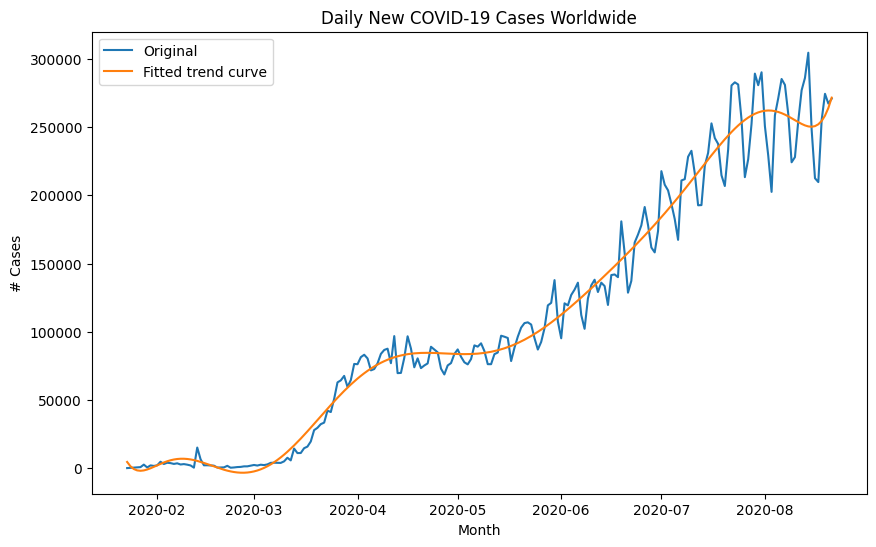

In [ ]:
# let's see the regression line

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, case_preds, label="Fitted trend curve")
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

Looks like a pretty good fit!

It's worth mentioning that the `seaborn` library provides a function [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) that can plot both the data and the regression line in a few lines of code, thus saving you the trouble of fitting a regression model.

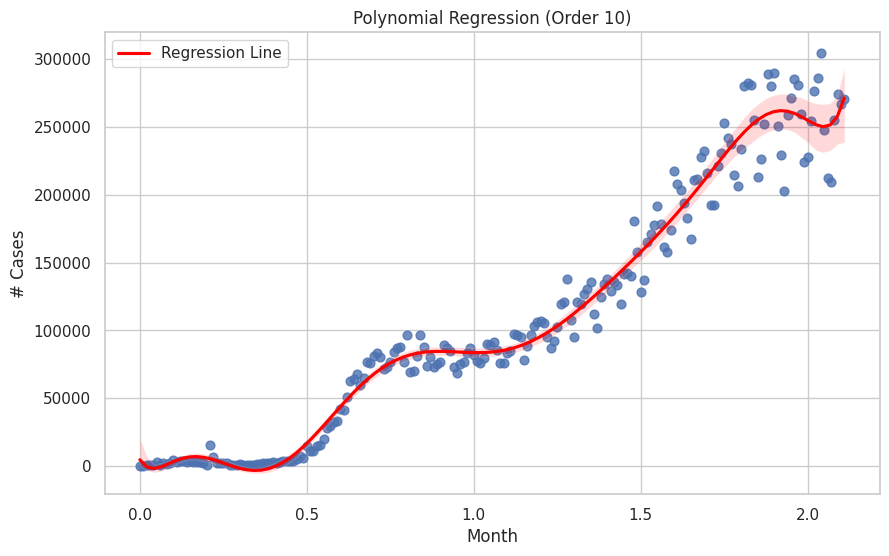

In [ ]:
# Create a scatter plot with regression line using seaborn's regplot
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.regplot(x=train_X, y=train_y, order=10, scatter_kws={'s': 40}, line_kws={'color': 'red', 'label': 'Regression Line'})
plt.xlabel('Month')
plt.ylabel('# Cases')
plt.title(f'Polynomial Regression (Order 10)')
plt.legend()
plt.show()

In [ ]:
### YOUR CODE: try a different polynomial order (i.e., other than 10)
### then, use it to make predictions and assess performance
### how does its performance compare to the 10th order polynomial?



In [ ]:
### EXAMPLE ANSWER

# fit a 12th order polynomial to the time series
train_X_poly = PolynomialFeatures(12).fit_transform(train_X.reshape(-1, 1))
lin_reg = LinearRegression().fit(train_X_poly, train_y.reshape(-1))

# make predictions
case_preds = lin_reg.predict(train_X_poly)
# assess predictions
r2_score(train_y, case_preds) # does slightly better!

0.9742818082633287

### 4. Calculating a Weighted Moving Average (WMA)

The regression method seems to give a fairly accurate description of the trend hidden in the time series. In this section and the next, we will explore an alternative method for discovering trends that is based on moving averages.

Recall from the lectures that a Weighted Moving Average (WMA) method applies the following transformation to each data point $x_{j}$:

\begin{align}
x_{j}^{\prime} &=
\frac{w_{k}x_{j} + w_{k - 1}x_{j - 1} + \cdots + w_{1}x_{j - k + 1}}{w_{k} + w_{k - 1} + \cdots + w_{1}} & \text{if } j > k \\ \\
x_{j}^{\prime} &= \frac{w_{k}x_{j} + w_{k - 1}x_{j - 1} + \cdots + w_{k - j + 1}x_{1}}{w_{k} + w_{k - 1} + \cdots + w_{k - j + 1}} & \text{if } j \leq k
\end{align}

for a window of size $k$. In the code below, we will calculate the WMA for our input time series.

In [ ]:
import numpy as np

In [ ]:
wd_size = 7 # our window size, k
weights = np.arange(1, wd_size + 1).astype(float) # linear weighting
print(weights)

[1. 2. 3. 4. 5. 6. 7.]


In [ ]:
# compute WMA
wma = []
for i in range(len(daily_new_cases)): # loop through case counts
    low, high = max(0, i - wd_size + 1), i + 1 # get current window
    wma.append(np.average(daily_new_cases.iloc[low: high], weights=weights[-(high - low):])) # compute average
wma = np.array(wma) # convert to an array

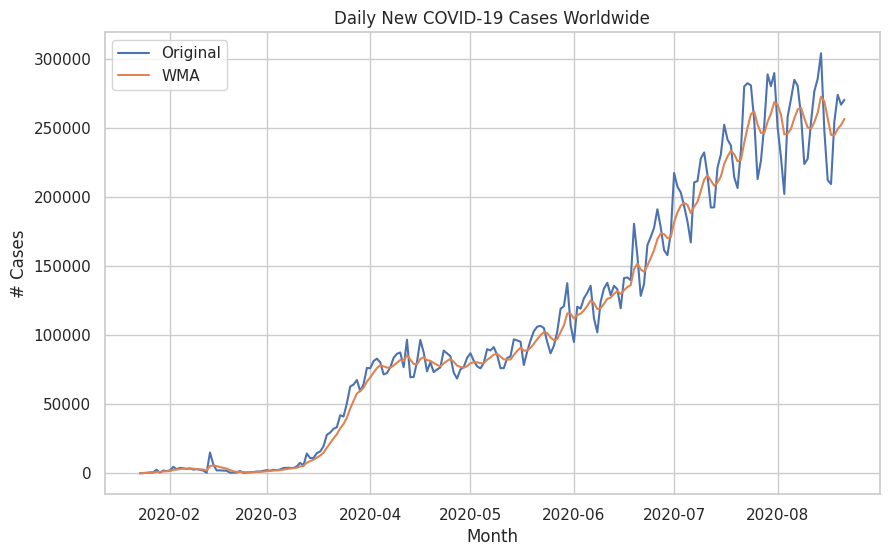

In [ ]:
# let's plot our WMA

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, wma, label="WMA")
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

In [ ]:
### YOUR CODE: try out a window size of 3 and a window size of 10
### how do the resulting trend curves compare to that above? does this make sense given the formula for WMA?



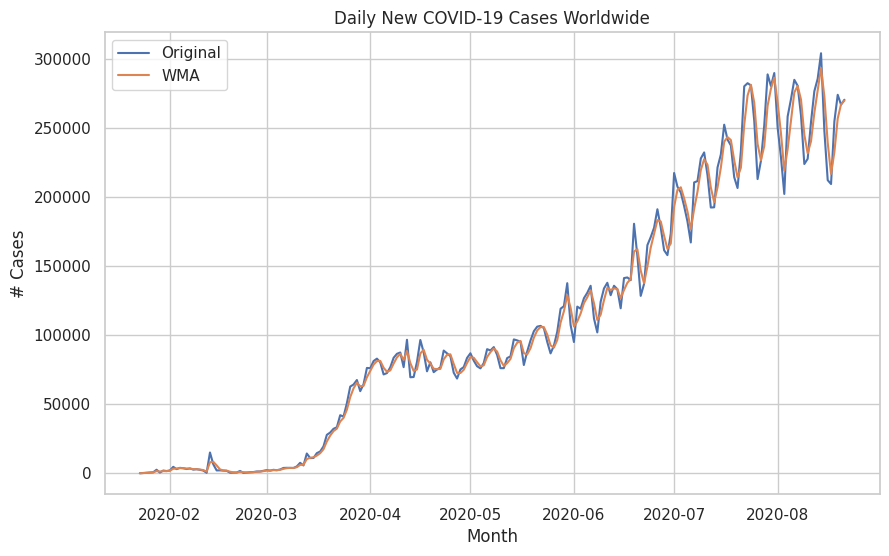

In [ ]:
### EXAMPLE ANSWER:

wd_size = 3 # our window size, k
weights = np.arange(1, wd_size + 1).astype(float) # linear weighting

# compute WMA
wma = []
for i in range(len(daily_new_cases)): # loop through case counts
    low, high = max(0, i - wd_size + 1), i + 1 # get current window
    wma.append(np.average(daily_new_cases.iloc[low: high], weights=weights[-(high - low):])) # compute average
wma = np.array(wma) # convert to an array

# let's plot our WMA

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, wma, label="WMA")
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend() # with a window size of 3, trend curve follows actual observed line much more closely

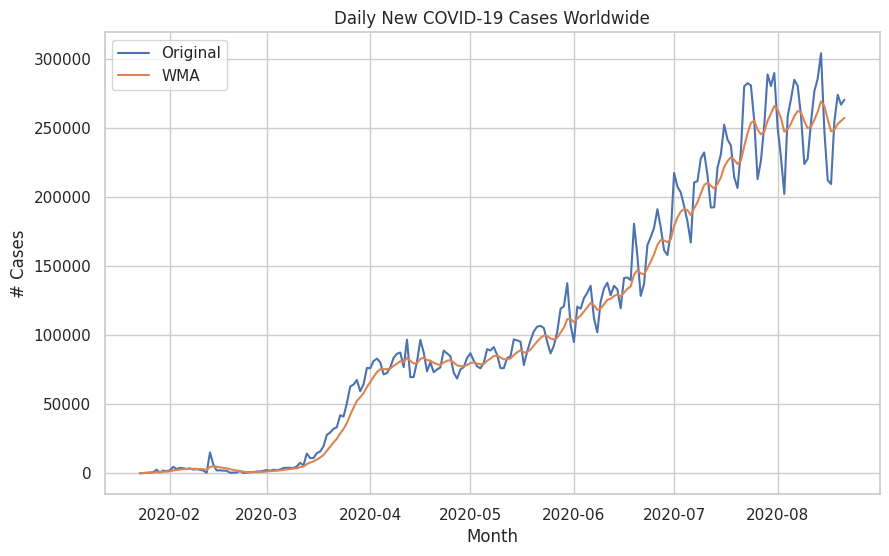

In [ ]:
### EXAMPLE ANSWER (cont.):

wd_size = 10 # our window size, k
weights = np.arange(1, wd_size + 1).astype(float) # linear weighting

# compute WMA
wma = []
for i in range(len(daily_new_cases)): # loop through case counts
    low, high = max(0, i - wd_size + 1), i + 1 # get current window
    wma.append(np.average(daily_new_cases.iloc[low: high], weights=weights[-(high - low):])) # compute average
wma = np.array(wma) # convert to an array

# let's plot our WMA

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, wma, label="WMA")
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend() # with a window size of 10, see less fluctuation in our trend curve, smoother

### 5. Calculating the "Time" Exponential Moving Average (EMA)

WMA usually works well if each data point is sampled at regular time intervals (which is the case for our time series). "Time" Exponential Moving Average (EMA), on the other hand, works well on both regular and irregular time series. Let's now explore how to apply EMA to our time series.

Recall from the lectures that a "time" EMA method applies the following transformation to each data point $x_{j}$:

\begin{equation*}
x_{j}^{\prime} = \frac{\sum_{i = 1}^{j}\exp\left[-\lambda\left(t_{j} - t_{i}\right)\right]x_{i}}{\sum_{i = 1}^{j}\exp\left[-\lambda\left(t_{j} - t_{i}\right)\right]}
\end{equation*}

where $0 \leq \lambda \leq 1$ is the "decay rate". Also note that, when $\lambda = 0$, this is equivalent to a cumulative moving average (CMA). In the code below, we will calculate the "time" EMA for our input time series, **assuming the time intervals are days**.

In [ ]:
# assuming the time intervals are days
time_diff = (daily_new_cases.index.to_series() - daily_new_cases.index[0]).apply(lambda x: x.days).to_numpy()
time_diff

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
time_ema = []
lmbd = 0.5 # setting value for lmbd to be 0.5
for i in range(len(daily_new_cases)): # loop through case counts
    weights = np.exp(-lmbd * time_diff[i::-1]) # compute weights
    time_ema.append(np.average(daily_new_cases.iloc[: i + 1], weights=weights)) # calculate average
time_ema = np.array(time_ema) # convert results to an array

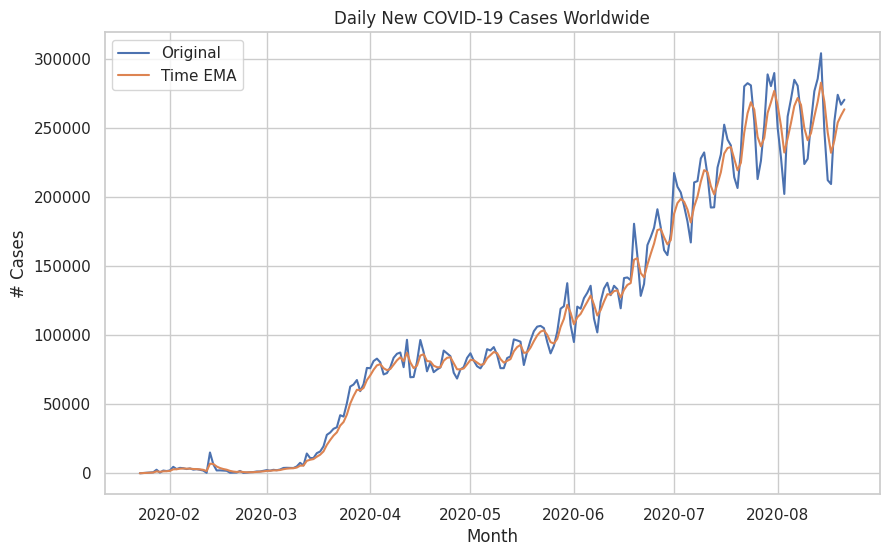

In [ ]:
# Let's plot our time EMA

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, time_ema, label="Time EMA")
ax.set_xlabel("Month")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

Note: The [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#) class from the `statsmodels` library is a handy tool for EMA. See an example below.

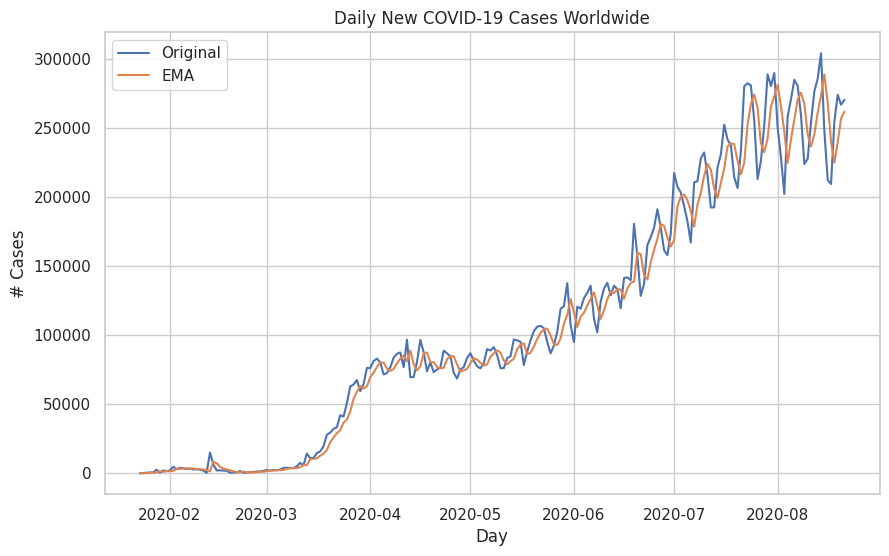

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

fig, ax = plt.subplots(figsize=(10, 6))

ema = SimpleExpSmoothing(daily_new_cases).fit(smoothing_level=0.5, optimized=False)

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(ema.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

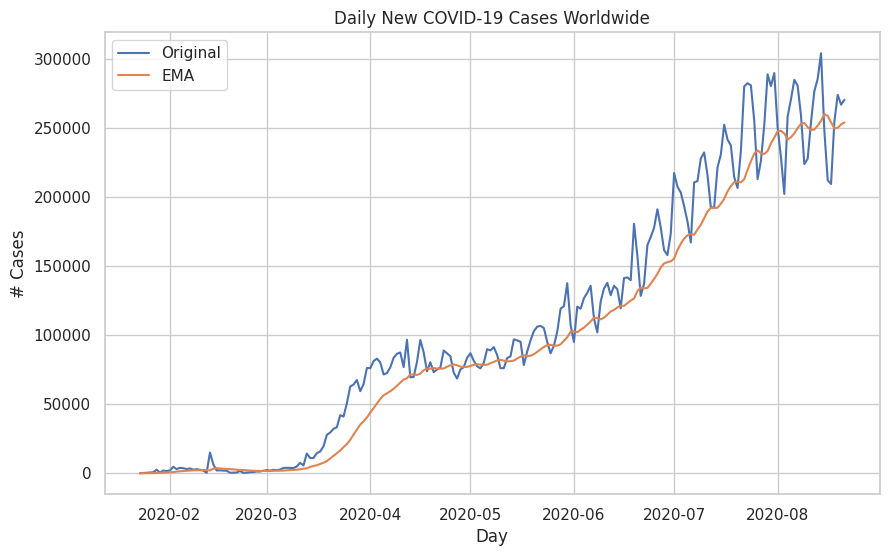

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ema = SimpleExpSmoothing(daily_new_cases).fit(smoothing_level=0.1, optimized=False)

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(ema.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

Higher $\lambda$ will lead to dramatic decrease in weights far from simple moving average.